# Lower Backpain
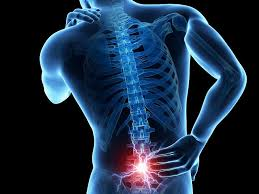

I  cannot think of anyone who has not encountered a backpain once in a while.

Urban Lifestyle,Corporate job, Constantly sitting in the same  position lead me into this uncomfortable and undesirable condition.

However, it can be hard to differentiate on your own if the intensity is Normal or Abnormal.

Lower back pain is caused by injury to a muscle (strain) or ligament (sprain). Common causes include improper lifting, poor posture, lack of regular exercise, a fracture, a ruptured disc or arthritis.

While lower back pain is extremely common, the symptoms and severity of lower back pain vary greatly.

Often, the only symptom is pain in the lower back.

Most low back pain goes away on its own in two to four weeks.

A simple lower back muscle strain might be excruciating enough to necessitate an emergency room visit, while a degenerating disc might cause only mild, intermittent discomfort.Physiotherapy and pain relievers can help. A few cases may require surgery.

This data set is about to identify a person is abnormal or normal using collected physical spine details/data.

Kindly Upvote if you learned anything new !Motivates me to post further.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import os
# os.chdir("C:\\Users\\DILIP\\Downloads")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import statsmodels.api as sm
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df=pd.read_csv('/kaggle/input/lower-back-pain-symptoms-dataset/Dataset_spine.csv')
df.head()

Here the columns are not named,so now we name the columns.



Also Unnamed is not of any significance so we drop it.

In [ ]:
df.drop('Unnamed: 13',axis=1,inplace=True)

In [ ]:
df.columns = ['pelvic_incidence','pelvic tilt','lumbar_lordosis_angle','sacral_slope','pelvic_radius','degree_spondylolisthesis','pelvic_slope','Direct_tilt','thoracic_slope','cervical_tilt','sacrum_angle','scoliosis_slope','Status']

In [ ]:
df.head()

# Lets Explore:

In [ ]:
df.info()

In [ ]:
columns=df.columns
for i in columns:
    print(i,'has : ',df[i].nunique(),'Unique Values')

Now we know that this is a classification problem.

Status of the Spine is the target variable.

In [ ]:
print(df.Status.value_counts())
print(df.Status.describe())

As we can see that most people have an anomaly in the lower back, lets see what factors are contributing to it in our further course of study.The dataset has 210 abnormal values and 100 normal.The dataset has no class imbalance.

In [ ]:
df.isnull().sum()

Great!  No Null Values.

In [ ]:
df.describe().T

In most cases the mean is higher than median signifying that the data is positively skewed.However,this can also be due to outliers as the mean is affected by outliers in the data.

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df)
plt.show()

Let us see how all the variables are related with the target column.

In [ ]:
df.groupby('Status').mean()

In [ ]:
df.groupby('Status').median()

The mean corresponding to Abnormal for degree_spondylolisthesis is quite higher than the corresponding median,this is mainly because the degree_spondylolisthesis might be positively skewed or right skewed.Could be also due to outliers.

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(df['degree_spondylolisthesis'],bins=100, kde=True, color="blue")

We were completely right about the right skewness of the degree_spondylolisthesis.You can see that as above.

In [ ]:
df.skew()

In [ ]:
df.kurt()

Here we can see that almost all the features's skew are close to 0, except degree_spondylolisthesis, which has a right skew or a positive skew as seen above.

Also,kurtosis of all features is close to 0,which means most features are meso kurtic.Mesokurtic distributions are similar to normal distributions, in which extreme or outlier events are very unlikely.Great, so we know that majority of the events have no or little outliers.

However in case of sacral_slope and degree_spondylolisthesis the kurtosis is >0, which means they are Leptokurtic.Leptokurtic means the distributions are more peaked than usual.sharply peaked with heavy tails.


so we will just be transforming the degree_spondylolisthesis feature.

In [ ]:
df["deg1"]=(df["degree_spondylolisthesis"])**2

Lets plot the kernel density to know if there is any use of the transformation or not and compare:

In [ ]:
sns.set(style="darkgrid")
fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.kdeplot(df['degree_spondylolisthesis'],shade=True, color="black",ax=ax[0])
ax[0].set_title('degree_spondylolisthesis')
sns.kdeplot(df['deg1'],shade=True, color="black",ax=ax[1])
ax[1].set_title('degree_spondylolisthesis after applying Square transformation')
plt.show()


Here the power transformation has made it worst and given us no positive result.log transformation can often increase – not reduce – the variability of data whether or not there are outliers.Z score transform too, in this case will have no effect and hence we will se if we need to transform data or not after model building.

In [ ]:
df.drop('deg1',axis=1,inplace=True)

In [ ]:
correlation=df.corr()
correlation

pelvic_incidence is highly correlated with pelvic tilt, sacral slope, degree spondylolisthesis and lumbar lordosis angle.

 Lets see the pearsons correlation plot for it:

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cmap='seismic_r')

 Anything closer to +- 1 indicates high correlation between those two predictor variables.
 

As we can see from above, there is multicolinearity in the data.

To get a clearer view of correlation visually we use masking.
Masks are an array of boolean values for which a condition is met.

In [ ]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation, mask=mask, center=0, square=True, linewidths=.5,cmap='gist_ncar')

plt.show()

np.triu_indices_from:Returns the indices for the upper-triangle of an array.

So easy! Now, even a pleb can tell you which features are correlated:pelvic_incidence is highly correlated with pelvic tilt, sacral slope, degree spondylolisthesis and lumbar lordosis angle.

Lets see the relationship with the multicolinear variables with the target as below:

In [ ]:
sns.set(style="darkgrid")
fig,ax=plt.subplots(2,3,figsize=(15,8))
sns.swarmplot("Status","pelvic_incidence",data=df,ax=ax[0,0])
sns.swarmplot("Status","pelvic tilt",data=df,ax=ax[0,1])
sns.swarmplot("Status","sacral_slope",data=df,ax=ax[0,2])
sns.swarmplot("Status","degree_spondylolisthesis",data=df,ax=ax[1,0])
sns.swarmplot("Status","lumbar_lordosis_angle",data=df,ax=ax[1,1])
sns.swarmplot("Status","pelvic_radius",data=df,ax=ax[1,2])
plt.show()

Our Analysis from the above plots:

1.Pelvic_incidence >= 100 will lead to an Abnormal Lower Back for sure, Less than that can be either normal or abnormal.


2.Pelvic_tilt till 30 the Status can be normal or abnormal but if the pelvictitlt is somewhere greater than 30, then the spine is abnormal


3.Sacral_slope does not have much of a relationship with the Spinal Status.However if its >70  it can lead to an Abnormal Spine for sure, there are outliears here.


4.Normal Spine has a lower degree of Spondylolisthesis.


5.lumbar_lordosis_angle:The Abnormal and Normal spine both have outliers.lumbar_lordosis_angle till 100 or less than 100 can either lead to a Normal or an Abnormal Spine.


6.Pelvic_radius: A normal or Abnormal spines pelvic radius  can range in  between : 100 - 150. Any thing above or below will Definely lead to an Abnormal Spine .

In [ ]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='k')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

In [ ]:
fig, axes = plt.subplots(3, 4, figsize = (15,20))
axes = axes.flatten()
for i in range(0,len(df.columns)-1):
   
    sns.kdeplot(df.iloc[:,i], ax=axes[i],shade=True, color="r")

plt.tight_layout()
plt.show()

Most Variables are roughly Normal except the degree_spondylolisthesis.

degree_spondylolisthesis is having a positive skew.

In [ ]:
fig, axes = plt.subplots(3, 4, figsize = (15,20))
axes = axes.flatten()

for i in range(0,len(df.columns)-1):
    sns.boxenplot(x="Status", y=df.iloc[:,i], data=df, orient='v', ax=axes[i],palette="magma_r")

plt.tight_layout()
plt.show()

Boxenplots are used when we need to draw an enhanced box plot for larger datasets

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot('Status',data=df,palette="viridis_r")
plt.show()
df['Status'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(x ='Status', y='degree_spondylolisthesis',ax=ax,size=4,data=df, palette="PuRd") 
sns.boxplot(x ='Status', y='degree_spondylolisthesis',ax=ax,data=df)

We can Clearly see the presence of outliers in the degree_spondylolisthesis. But since its a Data used for medical purposes, we cannot drop anything as it will lead to information loss.

In [ ]:
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
col = "Status"
grouped = df[col].value_counts().reset_index()
grouped = grouped.rename(columns = {col : "count", "index" : col})

## plot
colors = ['magenta', 'purplr']
trace = go.Pie(labels=grouped[col], values=grouped['count'], pull=[0.05, 0],marker=dict(colors=colors, line=dict(color='#000000', width=2)))
layout = {'title': 'Status of Spine(Normal, Abnormal)'}
fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

67% of the variables correspond to the Abnormal Status. 32.3% contribute to the Normal Status.

# Logistic Regression:

Logistic regression is a type of regression analysis in statistics used for prediction of outcome of a categorical dependent variable from a set of predictor or independent variables. In logistic regression the dependent variable is always binary. Logistic regression is mainly used to for prediction and also calculating the probability of success.

In [ ]:
df["Status"]=pd.get_dummies(df["Status"],drop_first=True)

In [ ]:
from statsmodels.tools import add_constant as add_constant
df_constant = add_constant(df)
df_constant.head()

In [ ]:
cols=df_constant.columns[:-1]
model=sm.Logit(df.Status,df_constant[cols])
result=model.fit()
result.summary()

The results above show some of the attributes with P value higher than the preferred alpha(5%) and thereby showing low statistically significant relationship with the probability of Abnormal Spine. Backward elemination approach is used here to remove those attributes with highest Pvalue one at a time follwed by running the regression repeatedly until all attributes have P Values less than 0.05.

In [ ]:
def back_feature_elem (data_frame,dep_var,col_list):


    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(df_constant,df.Status,cols)

In [ ]:
result.summary()

When all features plugged in:

$$logit(p) = log(p/(1-p))=\beta_0 +\beta_1\hspace{.1cm} *\hspace{.2cm} Pelvic tilt\hspace{.2cm}+\beta_2\hspace{.1cm} * \hspace{.1cm}\hspace{.2cm}Sacral slope+\hspace{.2cm}\beta_3\hspace{.1cm} *\hspace{.1cm} Pelvic radius\hspace{.2cm}+\hspace{.2cm}\beta_4 \hspace{.1cm}*\hspace{.1cm} degree spondylolisthesis\hspace{.2cm}$$


# Interpreting the results: Odds Ratio, Confidence Intervals and Pvalues:

In [ ]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))


pelvic_radius has a negative co-efficient indicating that for every unit increase in the values of this variable, the log of odds of the Status being Abnormal decreases.
degree_spondylolisthesis has a positive relationship with Abnormal status i.e for every unit increase in the value of degree_spondylolisthesis the log of odds of the Status being Abnormal increases.

In [ ]:
import sklearn
new_features=df[['pelvic tilt','sacral_slope','pelvic_radius','degree_spondylolisthesis',"Status"]]
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

# Model Evaluation:

In [ ]:
sklearn.metrics.accuracy_score(y_test,y_pred)

Accuracy of our model is 88.7%

CONFUSION MATRIX: 



A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='gist_ncar')

The confusion matrix shows 37+18 = 55 correct predictions and 7 incorrect ones.

**<font color=DarkBlue>True Positives:**  18<font>

**<font color=DarkBlue>True Negatives:**  37<font>

**<font color=DarkBlue>False Positives:** 3(*Type I error*)<font>

**<font color=DarkBlue>False Negatives:** 4 ( *Type II error*)<font>

In [ ]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

# Model Evaluation Statistics:

In [ ]:
print('The acuuracy of the model = TP+TN / (TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n\n',

'The Miss-classification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n\n',

'Sensitivity or True Positive Rate = TP / (TP+FN) = ',TP/float(TP+FN),'\n\n',

'Specificity or True Negative Rate = TN / (TN+FP) = ',TN/float(TN+FP),'\n\n',

'Positive Predictive value = TP / (TP+FP) = ',TP/float(TP+FP),'\n\n',

'Negative predictive Value = TN / (TN+FN) = ',TN/float(TN+FN),'\n\n',

'Positive Likelihood Ratio = Sensitivity / (1-Specificity) = ',sensitivity/(1-specificity),'\n\n',

'Negative likelihood Ratio = (1-Sensitivity) / Specificity = ',(1-sensitivity)/specificity)


From the above statistics it is clear that the model is slightly specific than sensitive. The negative values are predicted comparately accurately than the positives.

### <font color= Blue>Predicted probabilities of  0 (Abnormal) and 1 ( Normal)  for the test data with a default classification threshold of 0.5 <font>


In [ ]:
y_pred_prob=logreg.predict_proba(x_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Prob of abnormal spine (0)','Prb of normal spine (1)'])
y_pred_prob_df.head()

We need to lower our threshold in order to increase our Sensitivity.Because,a  False Negative ( ignoring the probability of abnormal spine when there actualy is one) is more dangerous than a False Positive in this case

In [ ]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')
    

We were sucessful in increasing sensitivity.

# The AUC/ROC Curve:

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

A common way to visualize the trade-offs of different thresholds is by using an ROC curve, a plot of the true positive rate ( true positives/ total positives) versus the false positive rate ( false positives /total negatives) for all possible choices of thresholds.



A model with good classification accuracy should have significantly more true positives than false positives at all thresholds.



The optimum position for roc curve is towards the top left corner where the specificity and sensitivity are at optimum levels

Area Under The Curve (AUC)


The area under the ROC curve quantifies model classification accuracy ; the higher the area, the greater the disparity between true and false positives, and the stronger the model in classifying members of the training dataset.


An area of 0.5 corresponds to a model that performs no better than random classification and a good classifier stays as far away from that as possible. An area of 1 is ideal.
The closer the AUC to 1 the better.

In [ ]:
sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])

Great! We have received an amazing score. Model is build well.

# Class Imbalance:

In [ ]:
print('Abnormal', round(df['Status'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Normal', round(df['Status'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Most of the individuals have an Abnormal Spine.But it is also evident here that more than 20% of individuals also have a normal spine.So, no imbalance data treatment required here.